# Survival Analysis

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [64]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeNormalPmf
import thinkplot

from scipy.special import binom
import scipy.stats as stats


## The Weibull distribution

The Weibull distribution is often used in survival analysis because it models the distribution of lifetimes for manufactured products, at least over some parts of the range.

The following functions evaluate its PDF and CDF.

In [3]:
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

SciPy also provides functions to evaluate the Weibull distribution, which I'll use to check my implementation.

In [4]:
from scipy.stats import weibull_min

lam = 2
k = 1.5
x = 0.5

weibull_min.pdf(x, k, scale=lam)

0.33093633846922332

In [5]:
EvalWeibullPdf(x, lam, k)

0.33093633846922332

In [6]:
weibull_min.cdf(x, k, scale=lam)

0.1175030974154046

In [7]:
EvalWeibullCdf(x, lam, k)

0.11750309741540454

And here's what the PDF looks like, for these parameters.

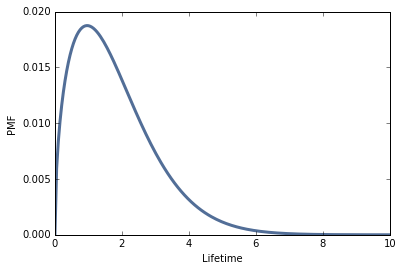

In [8]:
pmf = MakeWeibullPmf(lam, k, high=10)
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Lifetime',
                 ylabel='PMF')

We can use np.random.weibull to generate random values from a Weibull distribution with given parameters.

To check that it is correct, I generate a large sample and compare its CDF to the analytic CDF.

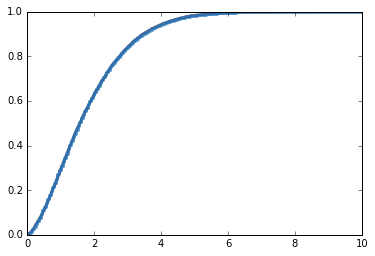

In [9]:
def SampleWeibull(lam, k, n=1):
    return np.random.weibull(k, size=n) * lam

data = SampleWeibull(lam, k, 10000)
cdf = Cdf(data)
model = pmf.MakeCdf()
thinkplot.Cdfs([cdf, model])

**Exercise:** Write a class called `LightBulb` that inherits from `Suite` and `Joint` and provides a `Likelihood` function that takes an observed lifespan as data and a tuple, `(lam, k)`, as a hypothesis.  It should return a likelihood proportional to the probability of the observed lifespan in a Weibull distribution with the given parameters.

Test your method by creating a `LightBulb` object with an appropriate prior and update it with a random sample from a Weibull distribution.

Plot the posterior distributions of `lam` and `k`.  As the sample size increases, does the posterior distribution converge on the values of `lam` and `k` used to generate the sample?

In [10]:
class LightBulb(Suite, Joint):
    '''data: float, lifespan of a bulb
    hypo: (lam, k) hypothetical parameters of Weibull distribution'''
    def Likelihood(self, data, hypo):
        x = data
        lam, k = hypo
        if lam == 0:
            return lam
        return EvalWeibullPdf(x, lam, k) # probability that it has a very particular lifespan

In [11]:
from itertools import product

ks = np.linspace(0, 10, 100)
lams = np.linspace(0, 10, 100)
weibulls = LightBulb(product(ks, lams))
weibulls.Update(1)

0.12214519932669819

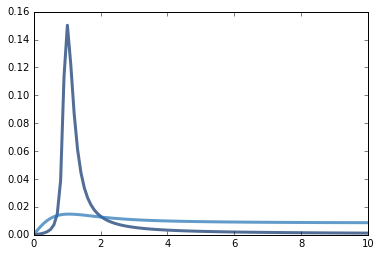

In [12]:
thinkplot.Pdf(weibulls.Marginal(0))
thinkplot.Pdf(weibulls.Marginal(1))

In [13]:
# Solution goes here

In [14]:
# Solution goes here

In [15]:
# Solution goes here

**Exercise:** Now suppose that instead of observing a lifespan, `k`, you observe a lightbulb that has operated for 1 year and is still working.  Write another version of `LightBulb` that takes data in this form and performs an update. 

In [16]:
class LightBulb(Suite, Joint):
    '''data: float, lifespan of a bulb
    hypo: (lam, k) hypothetical parameters of Weibull distribution'''
    def Likelihood(self, data, hypo):
        x = data
        lam, k = hypo
        if lam == 0:
            return lam
        return 1 - EvalWeibullCdf(x, lam, k) # probability that it has a lifespan greater than observed

In [17]:
ks = np.linspace(0, 10, 100)
lams = np.linspace(0, 10, 100)
weibulls = LightBulb(product(lams, ks))
weibulls.Update(1)

0.83560810182556289

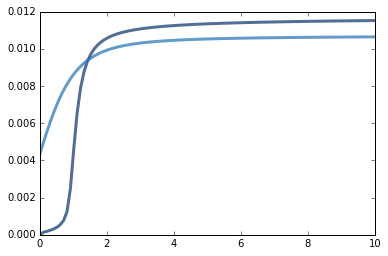

In [18]:
thinkplot.Pdf(weibulls.Marginal(0))
thinkplot.Pdf(weibulls.Marginal(1))

In [19]:
# Solution goes here

In [20]:
# Solution goes here

**Exercise:** Now let's put it all together.  Suppose you have 15 lightbulbs installed at different times over a 10 year period.  When you observe them, some have died and some are still working.  Write a version of `LightBulb` that takes data in the form of a `(flag, x)` tuple, where:

1. If `flag` is `eq`, it means that `x` is the actual lifespan of a bulb that has died.
2. If `flag` is `gt`, it means that `x` is the current age of a bulb that is still working, so it is a lower bound on the lifespan.

To help you test, I will generate some fake data.

First, I'll generate a Pandas DataFrame with random start times and lifespans.  The columns are:

`start`: time when the bulb was installed

`lifespan`: lifespan of the bulb in years

`end`: time when bulb died or will die

`age_t`: age of the bulb at t=10

In [21]:
import pandas as pd

lam = 2
k = 1.5
n = 15
t_end = 10
starts = np.random.uniform(0, t_end, n)
lifespans = SampleWeibull(lam, k, n)

df = pd.DataFrame({'start': starts, 'lifespan': lifespans})
df['end'] = df.start + df.lifespan
df['age_t'] = t_end - df.start

df.head()

,lifespan,start,end,age_t
0,1.886260,5.255007,7.141267,4.744993
1,1.323245,5.608892,6.932137,4.391108
2,1.848614,6.414813,8.263426,3.585187
3,2.105641,3.928011,6.033651,6.071989
4,2.471331,8.957732,11.429062,1.042268


Now I'll process the DataFrame to generate data in the form we want for the update.

In [22]:
data = []
for i, row in df.iterrows():
    if row.end < t_end:
        data.append(('eq', row.lifespan))
    else:
        data.append(('gt', row.age_t))
        
for pair in data:
    print(pair)

('eq', 1.8862604243956809)
('eq', 1.3232447024349487)
('eq', 1.8486135006966133)
('eq', 2.1056406413221365)
('gt', 1.0422684369065465)
('eq', 1.7714182660442119)
('gt', 2.1759732489465495)
('eq', 0.27996759602810256)
('gt', 0.10833403516246598)
('gt', 1.1870810583385207)
('eq', 0.42216873332321875)
('eq', 2.1324168682658593)
('eq', 2.3469920361599623)
('eq', 0.67174296307140846)
('gt', 0.24409967158458024)


In [23]:
class LightBulb(Suite, Joint):
    '''data: (flag, x) where flag is either eq, meaning that x is when the bulb died, 
    or gt which means the bulb is still working at time x
    hypo: lam, k of possible weibull distribution to model the bulb life'''
    def Likelihood(self, data, hypo):
        lam, k = hypo
        flag, x = data
        if lam == 0:
            return 0
        if flag == 'eq':
            return EvalWeibullPdf(x, lam, k)
        else: # flag == 'et':
            return 1 - EvalWeibullCdf(x, lam, k)

In [24]:
# first create a pmf for all the possible lambda/k combinations
ks = np.linspace(0, 10, 100)
lams = np.linspace(0, 10, 100)
weibulls = LightBulb(product(lams, ks))
weibulls.UpdateSet(data)

1.5564383434530333e-08

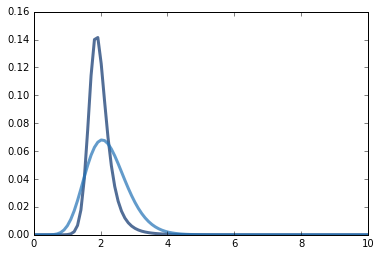

In [25]:
thinkplot.Pdf(weibulls.Marginal(0)) # lambda
thinkplot.Pdf(weibulls.Marginal(1)) # k

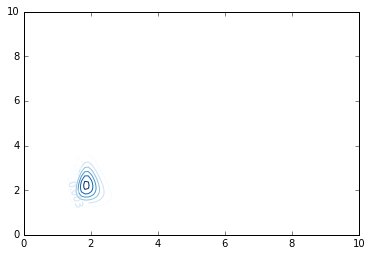

In [26]:
thinkplot.Contour(weibulls)

In [27]:
# Solution goes here

**Exercise:** Suppose you install a light bulb and then you don't check on it for a year, but when you come back, you find that it has burned out.  Extend `LightBulb` to handle this kind of data, too.

In [28]:
class LightBulb(Suite, Joint):
    '''data: (flag, x) where flag is either eq, meaning that x is when the bulb died, 
    or gt which means the bulb is still working at time x, or db which means x is the time
    between installation and discovering a dead bulb (you don't know when it died in that timespan)
    hypo: lam, k of possible weibull distribution to model the bulb life'''
    def Likelihood(self, data, hypo):
        lam, k = hypo
        flag, x = data
        if lam == 0:
            return 0
        if flag == 'eq':
            return EvalWeibullPdf(x, lam, k)
        if flag == 'et':
            return 1 - EvalWeibullCdf(x, lam, k)
        else: # if x is time between installation and discovering dead bulb
            return EvalWeibullCdf(x, lam, k) # sum up all of the probabilities of life before x,
                                        # because it could have died at any point

## Prediction

**Exercise:** Suppose we know that, for a particular kind of lightbulb in a particular location, the distribution of lifespans is well modeled by a Weibull distribution with `lam=2` and `k=1.5`.  If we install `n=100` lightbulbs and come back one year later, what is the distribution of `c`, the number of lightbulbs that have burned out?

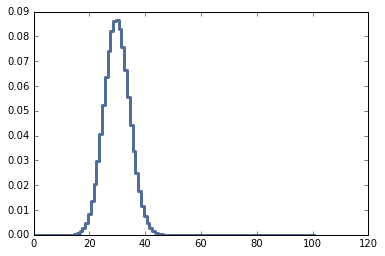

In [29]:
# we look for the distribution of c, so 1 to 100 of the bulbs could be dead
n = 100
c = range(1, n + 1)
x = 1
lam = 2
k = 1.5
pmf = Pmf()
for num_dead in c:
    # what is the likelihood that that number of bulbs is dead after 1 year
    like = stats.binom.pmf(num_dead, n, EvalWeibullCdf(x, lam, k))
    pmf[num_dead] = like
thinkplot.Pmf(pmf)

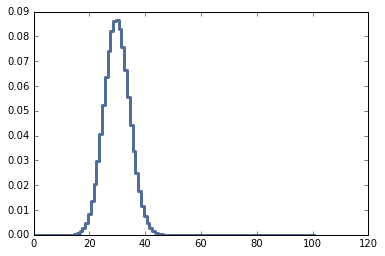

In [32]:
# Can be substituted by just making a binomial pmf!
# Where n is number of bulbs and p is the probability of them being dead (weibull)
def GetDistributionOfDeadBulbs(lam, k, n):
    pmf = Pmf()
    for num_dead in range(1, n + 1):
        # what is the likelihood that that number of bulbs is dead after 1 year
        like = stats.binom.pmf(num_dead, n, EvalWeibullCdf(x, lam, k))
        pmf[num_dead] = like
    pmf.Normalize()
    return pmf

thinkplot.Pmf(GetDistributionOfDeadBulbs(2, 1.5, 100))

**Exercise:** Now suppose that `lam` and `k` are not known precisely, but we have a `LightBulb` object that represents the joint posterior distribution of the parameters after seeing some data.  Compute the posterior predictive distribution for `c`, the number of bulbs burned out after one year.

In [88]:
# Now I have a bunch of different lams and ks, and for each I need to evaluate
# the c distribution, and then create a mixture of them!
ks = np.linspace(0, 10, 100)
lams = np.linspace(0, 10, 100)
weibulls = LightBulb(product(lams, ks))
weibulls.UpdateSet(data)

2.239895142790267e-11

In [89]:
from thinkbayes2 import MakeMixture
from thinkbayes2 import MakeBinomialPmf

def MakePmfOfDistributions(suite):
    metapmf = Pmf()
    for weibull, prob in suite.Items():
        lam, k = weibull
        #pmf = GetDistributionOfDeadBulbs(lam, k, 100)
        pmf = MakeBinomialPmf(100, EvalWeibullCdf(1, lam, k))
        metapmf[pmf] = prob
    mix = MakeMixture(metapmf, label=suite.label)
    return mix

In [90]:
c_distribution = MakePmfOfDistributions(weibulls)


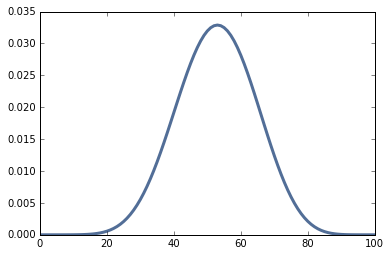

In [91]:
thinkplot.Pdf(c_distribution)

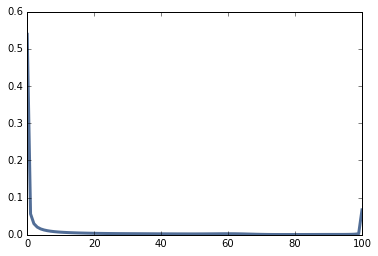

In [57]:
metapmf = Pmf()
n = 100
t_return = 1
for (lam, k), prob in weibulls.Items():
    p = EvalWeibullCdf(t_return, lam, k)
    pmf = MakeBinomialPmf(n, p)
    metapmf[pmf] = prob
mix = MakeMixture(metapmf)
thinkplot.Pdf(mix)

In [77]:
a = weibulls.Sample(1)
a[0]

array([ 2.42424242,  1.91919192])

In [87]:
b = MakeNormalPmf(0.5, 2, 4)
#thinkplot.Pmf(b)
c = b.MakeCdf(1001).Sample(1)
print(c[0])

-1.82


Imagine we have put an arrow into a person's knee at t = x1, an arrow into person's elbow at t = x2, and an arrow into their heel at t = x3. You don't know which arrow killed them. What is the probability that they have an Achille's heel? This should be an interesting problem because depending on where they were hit when, they could have died of blood loss...

Hmm, if I went through movies and saw how long it took people to die with different wounds, I could make distributions of survival based on these and then having a distribution for a knee, foot, and a head could tell you what the patient was suffering from if I know that he dies at some time t, or is still alive!